In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse,signal,interpolate
from numpy import polynomial


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os,sys
sys.path.insert(0, '..')
from partial_trace import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2
import os

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

$\renewcommand{\vec}{\mathbf}$

In [3]:
s = 1/2
M = int(2*s+1)

N = 12
n = M**N

N_s = 2
N_b = N-N_s
d_a = M**N_s
d_b = M**N_b

In [4]:
J_t = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if np.abs(i-j)==1:
            J_t[i,j] = 1

In [5]:
%%time
J = 1
h = .3*J

H = get_hamiltonian((J/2)*J_t,(J/2)*J_t,0*J_t,h,s)

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 103 ms


In [6]:
Λ,V = np.linalg.eigh(H.A)

In [7]:
Λ = np.linalg.eigvalsh(H.A)

In [8]:
E0 = np.min(Λ)

In [9]:
n_βs = 200
βs = 1/np.logspace(-2,2,n_βs)

ks = [0,1,2,20]

var = np.zeros((n_βs,len(ks)))
for l,β in enumerate(βs):

    f = lambda x: np.exp(-β*(x-E0))

    for ki,k in enumerate(ks):
        var[l,ki] = 2 * np.linalg.norm(f(Λ[k:]))**2 / np.sum(f(Λ))**2

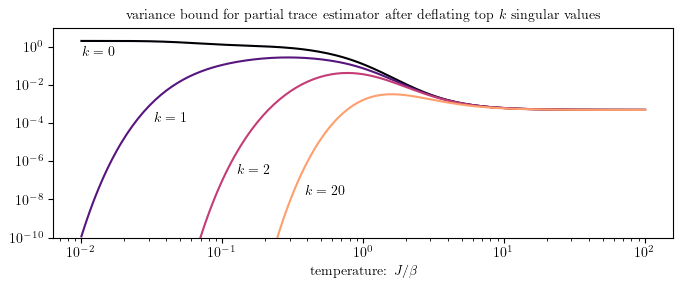

In [10]:
fig,axs = plt.subplots(1,1,figsize=(8,3))
plt.subplots_adjust(bottom=.18,wspace=.1)

c = plt.cm.magma(np.linspace(0,.8,len(ks)))
for ki,k in enumerate(ks):
    axs.plot(1/βs,var[:,ki],color=c[ki]);


axs.text(.1,.91,rf'$k={ks[0]}$',ha='right', va='top', transform=axs.transAxes)
axs.text(.215,.6,rf'$k={ks[1]}$',ha='right', va='top', transform=axs.transAxes)
axs.text(.35,.35,rf'$k={ks[2]}$',ha='right', va='top', transform=axs.transAxes)
axs.text(.47,.25,rf'$k={ks[3]}$',ha='right', va='top', transform=axs.transAxes)


axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylim(1e-10,10)

axs.set_title('variance bound for partial trace estimator after deflating top $k$ singular values',fontsize=10)
axs.set_xlabel(rf'temperature: $J/\beta$')

plt.savefig('imgs/variance_example.pdf')

In [11]:
n_βs = 200
βs = 1/np.logspace(-2,2,n_βs)

ks = [0,1,2,20]

var_sketch = np.zeros((n_βs,len(ks)))
for ki,k in enumerate(ks):
    print(ki)
    clear_output(wait=True)
    
    np.random.seed(0)
    Ω = np.random.randn(n,k)

    β_sketch = 1/2e-1
    f_sketch = lambda x: np.exp(-β_sketch*(x-E0))
    Q,_ = np.linalg.qr(f_sketch(Λ)[:,None]*Ω)
    
    for l,β in enumerate(βs):

        f = lambda x: np.exp(-β*(x-E0))

        fH_sketch = Q@(Q.T@(f(Λ)[:,None]*Q))@Q.T
        var_sketch[l,ki] = 2 * np.linalg.norm(fH_sketch-np.diag(f(Λ)))**2 / np.sum(f(Λ))**2

3


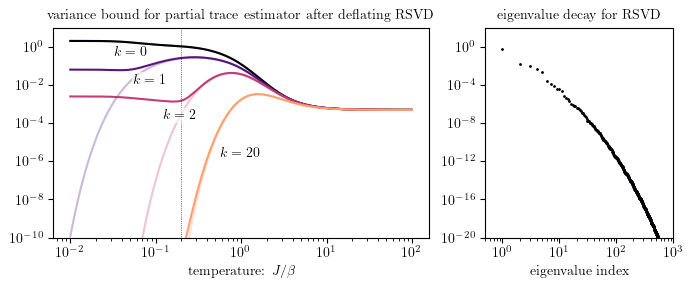

In [12]:
fig,axs = plt.subplots(1,2,figsize=(8,3),width_ratios=[2,1])
plt.subplots_adjust(bottom=.18,wspace=.2)

c = plt.cm.magma(np.linspace(0,.8,len(ks)))
for ki,k in enumerate(ks):
    axs[0].plot(1/βs,var_sketch[:,ki],color=c[ki]);
    axs[0].plot(1/βs,var[:,ki],color=c[ki],alpha=.3);


axs[0].text(.25,.91,rf'$k={ks[0]}$',ha='right', va='top', transform=axs[0].transAxes,bbox=dict(facecolor='white',alpha=.6,edgecolor='none',pad=1))
axs[0].text(.3,.78,rf'$k={ks[1]}$',ha='right', va='top', transform=axs[0].transAxes,bbox=dict(facecolor='white',alpha=.6,edgecolor='none',pad=1))
axs[0].text(.38,.61,rf'$k={ks[2]}$',ha='right', va='top', transform=axs[0].transAxes,bbox=dict(facecolor='white',alpha=.6,edgecolor='none',pad=1))
axs[0].text(.55,.43,rf'$k={ks[3]}$',ha='right', va='top', transform=axs[0].transAxes,bbox=dict(facecolor='white',alpha=.6,edgecolor='none',pad=1))

axs[0].axvline(1/β_sketch,color='k',lw=.5,ls=':')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1e-10,10)

axs[0].set_title('variance bound for partial trace estimator after deflating RSVD',fontsize=10)
axs[0].set_xlabel(rf'temperature: $J/\beta$')


#axins = axs.inset_axes([0.6, 0.2, 0.3, 0.6])
f = lambda x: np.exp(-β_sketch*(x-E0))
axs[1].plot(f(Λ),ls='None',marker='.',ms=2,color=c[0])
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylim(1e-20,1e2)
axs[1].set_xlim(5e-1,1e3)
axs[1].set_xticks([1,10,100,1000])
axs[1].set_title('eigenvalue decay for RSVD',fontsize=10)
axs[1].set_xlabel('eigenvalue index',fontsize=10)

plt.savefig('imgs/variance_example_sketch.pdf')